In [1]:
import seaborn as sns
import IPython
import math
import matplotlib.pyplot as plt
import joblib
import numpy as np
import numpy.matlib
import pandas as pd
import pydot
import pylab
import random
import scipy 
import scipy.cluster.hierarchy as shc
import scipy.stats as stats
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import tabulate
import boto3
import io
from io import StringIO
import os
import pickle

from numpy import linalg
from pylab import *
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.integrate import *
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform 
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, VotingClassifier, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, r2_score, make_scorer, mean_squared_error, mean_absolute_error,roc_curve,accuracy_score,roc_auc_score,brier_score_loss, precision_score, recall_score,f1_score, log_loss
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Importar funciones de utils
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/utils")

from utils import woe, validation, corr_plot, potencia, second_potencia, logistic_model, estim_prob

# Estimación de probabilidades de incumplimiento en el tiempo

## Introducción

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La **probabilidad de incumplimiento** se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más. Generalmente se cree que la probabilidad de incumplimiento es una cantidad que puede ser tomada como una etiqueta y que esa misma etiqueta puede usarse para definir tasas de productos (*pricing*), análisis temporal o credit scoring. En este trabajo se mostrará una forma de calcular probabilidad de incumplimiento en el tiempo y contrastarla con la forma de calcularlas para realizar Credit Scoring de créditos hipotecarios. 

Para la obtención de los modelos se utilizará metodologías de **optimización de problemas convexos**.


### Objetivo:

Identificar **periodos de crisis** y propuesta de **credit scoring** mediante el análisis de probabilidad de default (o de incumplimiento) de créditos hipotecarios de Estados Unidos, mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico, en específico, metodologías de optimización convexa.


### Datos:

Se utilizará la información de 60 trimestres de 5,000 créditos hipotecarios de Estados Unidos tomada de portafolios bursatilizados (RMBSs) a partir del año 2000 hasta 2015. El proveedor de la base es la instutición estadounidense [**International Financial Reasearch**](http://www.internationalfinancialresearch.org/). Cabe mencionar, que se  tiene acceso a ella por la adquisición del libro *Deep Credit Risk de Daniel Rosch y Harald Scheule*, el cual es la principal fuente de este proyecto.

A continuación, se enunciará y describirán las variables:

Dentro de la base de datos cada observación (*renglón*) corresponde a un préstamo otorgado por la institución hipotecaria.

1. *id*.- clave única por respondiente, dado que los préstamos se otorgan por distintos periodos de tiempo, el valor de esta variable se repite por varios préstamos (*renglones*).

1. *time*.- periodo observado identificado como trimestres deade el año $2000$ hasta $2015$, de tal manera que, $1$ corresponde al primer trimestre del año $2000$, $2$ al segundo trimestre del año $2000$, ...

1. *orig_time*.- trimestre en el que se otorgó el crédito. Si se otorgó previo al 2000, el número es negativo.

1. *first_time*.- trimestre en el que aparece el crédito se da de alta a la base de datos.

1. *mat_time*.- plazo del crédito (las unidades son trimestres).

1. *res_time*.- trimestre en el que se recuperó la vivienda.

1. *balance_time*.- saldo del respondiente al trimestre de observación. La unidad de medición son dólares americanos.

1. *LTV_time*.- Loan to Value a la originación (endeudamiento de un activo en relación con su valor real y actual). Para obtener una descripción más detallada se recomienda visitar el siguiente [link](https://www.ilpabogados.com/que-es-el-loan-to-value-ltv-y-por-que-es-relevante/). La unidad de medición son dólares americanos.

1. *interest_rate_time*.- tasa de interés en el trimestre correspondiente.

1. *rate_time*.- tasa libre de riesgo en el trimestre correspondiente.

1. *hpi_time*.- índice de precios de casas en el trimestre correspondiente.

1. *gdp_time*.- tasa de crecimiento del PIB en el trimestre correspondiente.

1. *uer_time*.- tasa de desempleo del trimestre correspondiente.

1. *REtype_CO_orig_time*.- identificador de condominio (condominio 1, en otro caso 0)

1. *REtype_PU_orig_time*.- identificador de desarrollo urbano (desarrollo urbano 1, en otro caso 0)

1. *REtype_SF_orig_time*.- identificador de vivienda familia unitaria (vivienda para una sola familia 1, en otro caso 0)

1. *investor_orig_time*.- identificador de  desarrollador (la casa fue construía por un desarrollador 1, en otro caso 0)

1. *balance_orig_time*.- monto del préstamo otorgado, las unidades de medición son dólares americanos.

1. *FICO_orig_time*.- [FICO score](https://www.ficoscore.com/ficoscore/pdf/Understanding-FICO-Scores-SPANISH.pdf) en el momento de originar el préstamo.

1. *LTV_orig_time*.- Loan to Value al momento de la originación del préstamo (las unidades de medición son dólares americanos).

1. *Interest_Rate_orig_time*.- tasa de interés del préstamo otorgado en el momento de la originación.

1. *state_orig_time*.- Estado de la unión americana donde se encuentra la vivienda.

1. *hpi_orig_time*.- índice de precios de casa al momento de la originación.

1. *default_time*.- indicadora de incumplimiento de pago (no se cumplió con la obligación de pagar el préstamo dado el trimestre correspondiente 1, en otro caso 0).

1. *payoff_time*.- indicadora de liquidación (liquidación 1, en otro caso 0).

1. *status_time*.- variable categórica con 3 niveles: 1 préstamo se declaró en default (no se cumplió con la obligación de pagarlo), 2 (se cumplió con la obligación de pagar), 0 en otro caso.

1. *lgd_time*.- [Loss given default](https://www.investopedia.com/terms/l/lossgivendefault.asp#:~:text=Loss%20given%20default%20(LGD)%20is,at%20the%20time%20of%20default.) o severidad al momento del default, las unidades de medición son dólares americanos.

1. *recovery_res*.- suma de los flujos recibidos durante el periodo de resolución, las unidades de medición son dólares americanos o bien, es el monto de  dinero que se recupera por adjudicar o quitar un inmueble.


### Temas

a. Análisis exploratorio de la base de datos: **EDA/GEDA**

	a.1 Describir la estructura de los datos
	
	a.2 Describir relaciones entre variables
	
	a.3 Mostrar gráficas y resultados (tablas) relevantes
	
	a.3 Identificar, analizar y describir Insights importantes


b. Selección de variables usando distintas herramientas: **Feature Enginering**
	
	b.1 Análisis de Probabilidades de incumplimiento en el tiempo: PCA.
	
	b.2 Credit Scoring: Mapeo WOE (weight of evidence) para obtención de Information Value.
	
c. Modelo de Regresión Logística para obtención de Probabilidades de incumplimiento en el tiempo: **Modelling**
	
	c.1 Selección de Técnica.
	
	c.2 Obtención de Parámetros.
	
	c.3 Análisis de medidas de validación.
	
	c.4 Proyección o estimación.
	
d. Modelo de Regresión para uso en Credit Scoring (sobre el mapeo de WOEś): **Modelling**
	
	d.1 Selección de Técnica.
	
	d.2 Obtención de Parámetros.
	
	d.3 Análisis de medidas de validación.
	
	d.5 Transformación a scorecards.
	
e. Conclusiones



### Software
Python y AWS



### Bibliografía:
1. *Rosch Daniel*, Scheule Harald. Deep Credit Risk. 2020. Amazon Fulfillment, Polonia.

1. *Siddiqi, Naeem*. Credit Risk Scorecards, Developing and Implementing Credit Scoring. 2006. Wiley, New Jersey 



### Integrantes y asignación de tareas del equipo

|User | Nombre Completo| Tarea |
|:---:|:---:|:---:|
|@oaperez3|Oscar Perez|Project manager, levantamiento de instancia en AWS, implementación de metodología, responder preguntas
|@Eduardo-Moreno|Eduardo Moreno|Investigación de variables, hardcodear código, implementación metodología, responder preguntas
|@yefovar|Yedam Fortiz|Testing, estudio de parte matemática, expositor
|@arenitss|Nayeli Arenas|Redacción, revisón de resultados, expositor




## Fórmulación matemática del problema de optimización convexa

Con el objetivo de obtener probabilidades (cumplen con los [axiomas de Kolmogorov](https://es.wikipedia.org/wiki/Axiomas_de_probabilidad#:~:text=Los%20axiomas%20de%20probabilidad%20son,formulados%20por%20Kolmog%C3%B3rov%20en%201933.)  ) se utiliza la regresión logística, que implícitamente hace mención a la función sigmoide $\sigma: \mathbb{R} \rightarrow \mathbb{R}$, que tiene la siguiente regla de correspondencia:

$$ \sigma(x) = \frac{1}{1+exp(-x)} $$

En este proyecto, se buscará identificar si un préstamo no cumplirá con sus oblicaciones (no pagar/default) o sí las cumplirá, para ello se identifica las siguientes 2 clases:

* $C_1$: el préstamo es catalogado como default (no cumple con las obligaciones de pago)
* $C_0$: el préstamo es catalogado como no default (sí cumple con las obligaciones de pago)

Así pues, utilizando la función sigmoide estimaremos la probabilidad de pertenecer a la clase $C_1$ dado una serie de métricas $x$:

$$ \mathbb{P}[C_1|x] = \sigma(a), \text{ para alguna } a \in \mathbb{R} $$


Utilizando el [Teorema de Bayes](https://es.wikipedia.org/wiki/Teorema_de_Bayes) es posible llegar al siguiente resultado:

$$ \mathbb{P}[C_1|x] = \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1]  } { \mathbb{P}[x|C_1] \mathbb{P}[C_1] + \mathbb{P}[x|C_0] \mathbb{P}[C_0] } = \frac{1} {1 + \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } } = \sigma(a) = \frac{1}{1+exp(-a)} $$


Por lo tanto,

$$ a(x) = log( \frac{ \mathbb{P}[x|C_1] \mathbb{P}[C_1] }{ \mathbb{P}[x|C_0] \mathbb{P}[C_0] } ) $$



El modelo de regresión logística (para $2$ clases) toma base de un modelo lineal en sus parámetros $\beta \in \mathbb{R}^n$ (donde $n$ indica la cantidad de variables/métricas a medir). Se añade un parámetro adicional $\beta_0$, por lo que el modelo tiene la siguiente forma:

$$ \beta^Tx + \beta_0= a(x|\beta, \beta_0) = log( \frac{ \mathbb{P}[C_1|x]  }{ \mathbb{P}[C_0|x]  } )  $$

Si $y$ es tomada como variable de respuesta, entonces se obtiene que está en función de $x \in \mathbb{R}^{n+1}$ dado el vector $\beta_0, \beta$. La regla de correspondencia es la siguiente:

$$ \mathbb{P}[C_1|x] = y(x | \beta_0, \beta) = \frac{ 1 } {1+exp(-(\beta_0 + \beta^Tx)) }  $$


En donde, la variable de optimización es $(\beta_0, \beta) \in \mathbb{R}^{n+1}$

Para el ajuste de los parámetros se utiliza la [metodología estudiada en el curso](https://itam-ds.github.io/analisis-numerico-computo-cientifico/III.optimizacion_convexa/3.3/Ejemplos_problemas_UCO_e_intro_CIEO_y_PI.html#como-se-ajustan-los-parametros-del-modelo-por-regresion-logistica-de-dos-clases), que se basa en maximizar la [función de verosimilitud](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_verosimilitud#:~:text=En%20estad%C3%ADstica%2C%20la%20funci%C3%B3n%20de,de%20un%20conjunto%20de%20observaciones.), que es equivalente a minimizar la función log-verosimilitud, el cual es equivalente a minimizar la [devianza](https://en.wikipedia.org/wiki/Deviance_(statistics)):

$$ \Large \text{min}_{\beta_0,\beta_1 \in \mathbb{R}^{n+1}} D(\beta_0, \beta|x) = -2 l(\beta_0, \beta|x) = \sum_{i=1}^m \text{log}( 1 + exp( (\beta_0,\beta )^Tx_i ) ) -\hat{y}_i(\beta_0,\beta )^Tx_i $$

En las notas del curso, se demuestra que la Hessiana de la devianza es una matriz simétrica semidefinida positiva y por tanto es una función convexa. Por lo que, en este proyecto se resolverá un **problema optimización (minimización) convexa.**

Este estudio minusioso de la función sigmoide y desarrollo matemático fue tomado del libro de [Optimización](https://itam-ds.github.io/analisis-numerico-computo-cientifico/README.html) cuyo autor es el profesor **Erick Moreno**.

# Análisis Exploratorio de Datos (*EDA*)

Como primer paso para este proyecto se realizará un análisis exploratorio de la base de datos.

### Lectura y preparación de datos

In [3]:
data = pd.read_csv('../data/data_t_final.csv')

Las dimensiones (cantidad de variables y observaciones) son

In [4]:
print('Cantidad de observaciones (renglones): ', data.shape[0])
print('Cantidad de variables: ', data.shape[1])

Cantidad de observaciones (renglones):  62178
Cantidad de variables:  28


Las variables con las que cuenta el `dataset` son las siguientes

In [5]:
for column in data.columns:
    print(column)

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


### Exploración de datos - datos faltantes

La proporción de valores faltantes por cada variables se muestra a continuación:

In [6]:
data.isna().mean()

id                         0.000000
time                       0.000000
orig_time                  0.000000
first_time                 0.000000
mat_time                   0.000000
res_time                   0.981344
balance_time               0.000000
LTV_time                   0.000402
interest_rate_time         0.000000
rate_time                  0.000000
hpi_time                   0.000000
gdp_time                   0.000000
uer_time                   0.000000
REtype_CO_orig_time        0.000000
REtype_PU_orig_time        0.000000
REtype_SF_orig_time        0.000000
investor_orig_time         0.000000
balance_orig_time          0.000000
FICO_orig_time             0.000000
LTV_orig_time              0.000000
Interest_Rate_orig_time    0.000000
state_orig_time            0.005629
hpi_orig_time              0.000000
default_time               0.000000
payoff_time                0.000000
status_time                0.000000
lgd_time                   0.975474
recovery_res               0

Las variables con mayor cantidad de valores faltantes son:
1. `res_time`.- periodo en el que se recuperó la vivienda.
1. `lgd_time`.- severidad al momento del default (declaración de incumplimiento de pago).
1. `recovery_res`.- suma de los flujos recibidos durante el periodo de resolución
1. `LTV_time`.- *Loan to Value* en el momento de la originación
1. `state_orig_time`.- Estado de la unión americana en donde se originó el préstamo

Se desconoce la razón real por la cual hay una cantidad muy alta de valores faltantes para dichas variables, sin embargo, se cree lo siguiente para las primeras $3$ variables:
 
* No se le dio el seguimiento requerido para capturar la fecha en la cual se recuperó la vivienda.
* No fue posible estimar la severidad o los montos por adjudicar bienes debido a falta de información (bienes mal valuados).
* Víctima de cyberataque.
* Fallo en los servidores que guardan la información.


Para las primeras $3$ variables la cantidad de valores faltantes es demasiado alta, de manera que si se omitieran dichos valores faltantes, entonces la base de datos contaría aproximadamente con el $2\%$ de las observaciones originales, por lo que se omitirán dichas variables y posteriormente se omitirán los valores faltantes que corresponden aproximadamente al $0.5629\%$. Cabe recalcar que se omiten debido a que si no se hiciese de tal manera se perdería la mayoría de la información que se encuentra en la base de datos y no se podría seguir con el análisis.

In [7]:
selected_data = data.drop(['res_time', 'lgd_time', 'recovery_res'], axis=1).dropna()
selected_data.isna().mean()

id                         0.0
time                       0.0
orig_time                  0.0
first_time                 0.0
mat_time                   0.0
balance_time               0.0
LTV_time                   0.0
interest_rate_time         0.0
rate_time                  0.0
hpi_time                   0.0
gdp_time                   0.0
uer_time                   0.0
REtype_CO_orig_time        0.0
REtype_PU_orig_time        0.0
REtype_SF_orig_time        0.0
investor_orig_time         0.0
balance_orig_time          0.0
FICO_orig_time             0.0
LTV_orig_time              0.0
Interest_Rate_orig_time    0.0
state_orig_time            0.0
hpi_orig_time              0.0
default_time               0.0
payoff_time                0.0
status_time                0.0
dtype: float64

In [8]:
print('Cantidad de observaciones (renglones): ', selected_data.shape[0])
print('Cantidad de variables: ', selected_data.shape[1])

Cantidad de observaciones (renglones):  61803
Cantidad de variables:  25


In [9]:
print('Porcentaje de observaciones (renglones) pérdidas: ', 100- selected_data.shape[0]/data.shape[0]*100, '%')
print('Porcentaje de variables pérdidas: ',100- selected_data.shape[1]/data.shape[1]*100, '%')

Porcentaje de observaciones (renglones) pérdidas:  0.6031072083373488 %
Porcentaje de variables pérdidas:  10.714285714285708 %


Se pierde menos del $1\%$ de información al omitir los obervaciones en donde se tenía valores faltantes ya fuese en la variable `state_orig_time` y/o `LTV_time`, el cual no es un porcentaje alto y la pérdida de información es mínima.

### Exploración de datos - estructura de variables

El `dataset` con el que se trabajará en el presente documento tiene la siguiente estructura

In [10]:
selected_data.head(5)

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,rate_time,hpi_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,4,25,-2,25,119,61031.10,33.911009,10.500,5.9,226.29,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
1,4,26,-2,25,119,60882.42,34.007232,10.500,5.9,225.10,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
2,4,27,-2,25,119,60729.80,34.335349,10.500,5.9,222.39,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
3,4,28,-2,25,119,60576.14,34.672545,10.875,5.9,219.67,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0
4,4,29,-2,25,119,60424.39,34.951639,10.875,5.9,217.37,...,0,63750.0,587,81.8,10.5,KY,97.99,0,0,0


Cabe recordar al lector, que cada observación (renglón) del `dataset` representa préstamos realizados a una determinada fecha, la cual indica el número de trimestre, iniciando desde el primer semestre del año $2000$ y finalizando en el último trimestre del año $2015$.

In [11]:
print('Cantidad de acreditados únicos: ', len(selected_data.id.unique()))
print('Cantidad de trimestres: ', len(selected_data.time.unique()))

Cantidad de acreditados únicos:  4979
Cantidad de trimestres:  60


Se le realizaron préstamos a $4,979$ personas distintas a lo largo de $60$ trimestres que corresponden a los $15$ años del periodo de estudio.

In [12]:
print('Cantidad de Estados: ', len(selected_data.state_orig_time.unique()))

Cantidad de Estados:  52


Se tiene información de los 52 estados que componene a Estados Unidos de América. La cantidad de observaciones por estado es la siguiente:

In [13]:
pd.crosstab(index=selected_data["state_orig_time"], columns="count").sort_values('count', ascending=False)

col_0,count
state_orig_time,
CA,12582
FL,6175
TX,3893
NY,2947
GA,2649
IL,2350
AZ,2171
VA,2070
OH,1726


Nótese que los estados con mayor cantidad de préstamos son:
1. California (CA)
1. Florida (FL)
1. Texas (TX)

Que corresponden a los estados con mayor población según [reportes](https://datosmacro.expansion.com/demografia/poblacion/usa-estados) al año 2019, por lo que, podría pensarse (faltaría comprobarlo) que los préstamos realizados siguen un comportamiento a distribución población, es decir, que depende de la cantidad de personas del estado la cantidad de préstamos realizados.

Al momento que se se genera un préstamo se cuenta con las siguienes variables:
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`
* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `state_orig_time`
* `hpi_orig_time`

Por lo que se enfocarán los esfuerzos, en primer lugar, a analizar dichas variables y en la variable `default_time`, ya que es la variable que nos indica si un préstamo fue catalogado como default (no cumplimiento con las obligaciones de pago), en el trimestre correspondiente o no.

In [14]:
selected_data[['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time',
             'balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'state_orig_time',
             'hpi_orig_time','default_time']].describe()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time
count,61803.000000,61803.000000,61803.000000,61803.000000,6.180300e+04,61803.000000,61803.000000,61803.000000,61803.000000,61803.000000
mean,0.061033,0.128198,0.607818,0.146271,2.551075e+05,673.489879,78.692758,5.595503,198.760887,0.024578
std,0.239392,0.334312,0.488241,0.353381,2.118775e+05,71.904099,10.226046,2.971053,33.428980,0.154837
min,0.000000,0.000000,0.000000,0.000000,6.246000e+03,429.000000,50.100000,0.000000,75.730000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.076230e+05,628.000000,75.000000,4.875000,186.910000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.880000e+05,675.000000,80.000000,6.250000,216.770000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,3.500000e+05,730.000000,80.000000,7.375000,223.750000,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.107000e+06,819.000000,119.800000,15.000000,226.290000,1.000000


Como ya se había mencionado previamente las variables `REtype_CO_orig_time`, `REtype_PU_orig_time`, `REtype_SF_orig_time`, `investor_orig_time` y `default_time` son binarias (sólo toman $2$) tal y como se había mencioando previamente. Además la proporción de $1$ en la variable de `default_time` es la menor. Que es un suceso esperado, esto quiere decir, que no todos los préstamos caen en default, es decir, no cumplen con sus obligaciones de pago. La variable `REtype_CO_orig_time` nos indica que la mayoría de los préstamos realizados corresponden a viviendas que **no** son condominios.

Un hecho interesante, es que la mayoría de los préstamos, son dados a viviendas que no tienen desarrollo urbano. Esto nos lo indica la media de `REtype_PU_orig_time`.

Para las variables numéricas se realizan los siguientes comentarios:
* `balance_orig_time`.- el monto del crédito mínimo fue aproximadamente de $\$255,107.5$ dólares, mientras que el más alto de casi $\$3,000,000$ dólares, lo cual nos indica que es una variable con alta dispersión.
* `FICO_orig_time`.- la desviación estándar es aproximadamente de $\$71$ dólares, dada la escala (mínimo y máximo), deducimos que no presenta una alta dispersión.
* `LTV_orig_time`.- análogo a la variable anterior.
* `Interest_Rate_orig_time`.- es interesante que la tasa de interés mínima fue de $0\%$, lo cual, indica que para dicho préstamo, no se generaron intereses. Sin embargo, la tasa máxima de interés fue de $15\%$.
* `hpi_orig_time`.- dada la escala de las variables y la desviación estándar, concluímos que no posee una alta dispersión.

El siguiente paso del análisis exploratorio es observar la dispersión de los datos para ello utilizaremos diagramas de cajas y brazos únicamente de las variables siguientes:

* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `hpi_orig_time`

Debido a que son las variables que se obtienen al momento de generar el préstamo, a continuación se analizarán los diagramas de caja para dichas variables en escala logarítmica, ya que hemos analizado que presentan una alta dispersión.

In [15]:
variables = ['balance_orig_time', 'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']

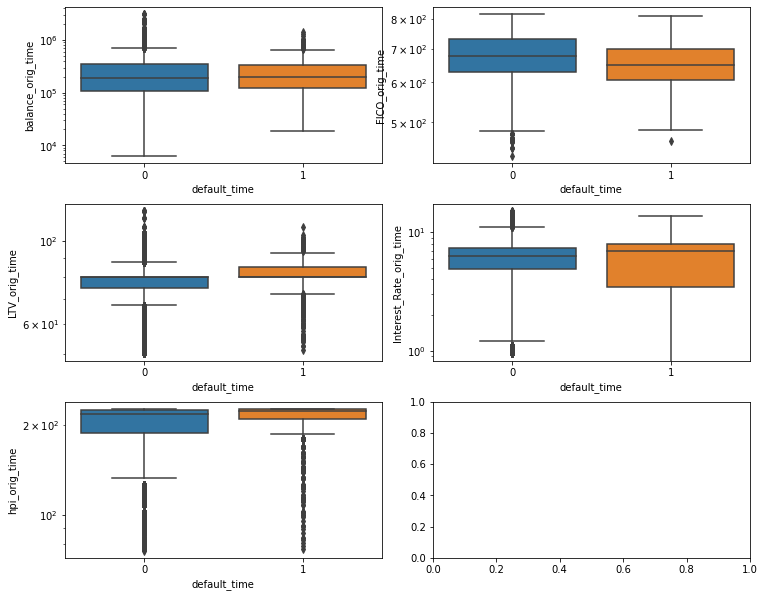

In [16]:
n = len(variables)
fig, ax = plt.subplots(3,2, figsize=(10.5,8.5))
#fig.set_size_inches(5.5, 20.5)
loc_i = [0,0,1,1,2]
loc_j = [0,1,0,1,0]
fig.tight_layout(pad=2)

for i in range(n):
    g = sns.boxplot(x='default_time', y = variables[i], data = selected_data, ax = ax[loc_i[i]][loc_j[i]])
    g.set(yscale = 'log')

La variable `balance_orig_time`, presenta una estructura muy similar para ambas categorías de la varaible `default_time`, sin embargo, la cantidad de valores atípicos para la clase $0$ son mayores.

Notemos que para las variables `Interest_Rate_orig_time` y `LTV_orig_time` la media es superior para el grupo identificado como *default* (o clase $1$) que para el *no default*. Mientras que para la variable `FICO_orig_time` ocurre lo contrario. Además, la dispersión para el grupo *default* de la variable `Interest_Rate_orig_time` es mayor y para la variable `hpi_orig_time` es mayor para el grupo *no default*.

Para las variables dicotómicas a continuación se calculará la desviación estándar y la media, dichas variables son las siguientes:
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`

In [17]:
var_dic = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time', 
           'default_time']

In [18]:
selected_data[var_dic].groupby(['default_time']).mean()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time
default_time,,,,
0,0.061277,0.128094,0.607176,0.14639
1,0.051350,0.132324,0.633311,0.14154


Notemos que la proporción para las variables dicotómias es muy parecida a excepción de la variable `REtype_SF_orig_time`, que indica la proporción de préstamos realizados a individuos con vivienda unitaria. Nótese que esta proporción es mayor para la categoría *default* (aquellos préstamos que no cumplieron con sus obligaciones de pago). Ante este fenónemo tenemos la siguiente hipótesis:
* Dado que es una vivienda unitaria, el ingreso se limita a lo recibido por una persona que en el caso donde no es unitaria y existen más aportadores de ingresos a la economía del hogar, por lo que, para el primer caso cumplir con las obligaciones de pago puede llegar a ser más difícil que para el segundo.

In [19]:
selected_data[var_dic].groupby(['default_time']).std()

,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time
default_time,,,,
0,0.239839,0.334197,0.488382,0.353500
1,0.220782,0.338954,0.482059,0.348693


La desviación estándar es muy similar para todas las variables dicotómicas.

Por último, se analizará la estructura de correlación entre las variables numéricas generadas al momento de realizar un préstamo. **¿Por qué se analiza la correlación?** Debido a que se utilizará un modelo lineal, el cual presenta problemas de inestibilidad numérica cuando se tienen variables con correlación lineal alta. 

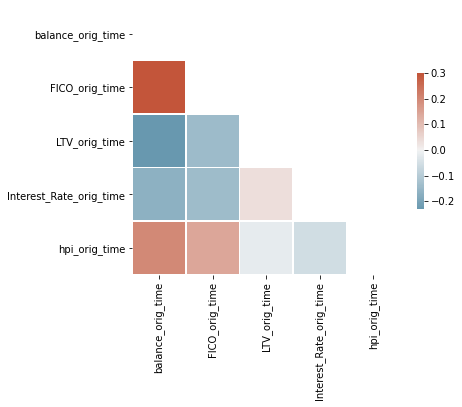

In [20]:
corr_plot(selected_data, variables)

El previo gráfico muestra las correlaciones lineales por variables, del cual se deduce que para las variables numéricas esta correlación es baja, por lo que el uso del modelo de regresión logística no debería presentar problemas de inestabilidad numérica para dichas variables.

### EDA - Hallazgos importantes 
* Las variables que se obtienen la momento de generar un préstamo no presentan una estructura alta de correlación, lo cual ayuda al modelo de regresión logística en el problema de multicolinealidad.
* Dichas variables por sí solas, no ayudan a distinguir los préstamos que caerán en default o no, por lo que será necesario de técnicas más robustas para tratar dichas variables (transformaciones **no lineales**).
* La distribución de préstamos realizados en Estados Unidos de América pareciése que sigue un comportamiento poblacional.
* La proporción de viviendas unitarias presentan una mayor tasa de *default* (no cumplir con obligación de pago) que las viviendas no unitarias.

## Modelling 

Una vez llegados a este punto, se trabajará con el *dataset* `selected_data` obtenido después de limpiar los valores faltantes.

A continuación seleccionaremos las variables que se poseen al momento de la originación de un préstamo, dichas variables son las siguientes:
* `id`
* `REtype_CO_orig_time`
* `REtype_PU_orig_time`
* `REtype_SF_orig_time`
* `investor_orig_time`
* `balance_orig_time`
* `FICO_orig_time`
* `LTV_orig_time`
* `Interest_Rate_orig_time`
* `state_orig_time`
* `hpi_orig_time`
* `default_time`

Cabe mencionar que la **variable dependiente** es `default_time`

In [21]:
data_modelling = selected_data[["id","REtype_CO_orig_time","REtype_PU_orig_time","REtype_SF_orig_time",
                                "investor_orig_time","balance_orig_time","FICO_orig_time","LTV_orig_time",
                                "Interest_Rate_orig_time","state_orig_time","hpi_orig_time","default_time"]]

Seleccionamos los préstamos que fueron catalogados en *default* (no cumplir con la obligación de pago) en su respectivo trimestre

In [22]:
data_default = data_modelling[(data_modelling.default_time == 1)]

Ahora los que no catalogados como *default*

In [23]:
data_no_default_aux = data_modelling[~data_modelling.id.isin(data_default.id.values)]
data_no_default = data_no_default_aux.drop_duplicates(subset = ["id"])

Y por último juntamos ambas particiones, esto con el fin de tener ordenada la base de datos en relación a la variable dependiente.

In [24]:
data_score = data_default.append(data_no_default)

### Cálculo Weight of **Evidence** (*WOE*) y **IV** (*IV*)

El [*WOE*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Weight-of-Evidence-WOE-), acrónimo de Weight of Evidente puede llegar a ser confuso al inicio, pues no es un término muy conocido, sin embargo, su sencillez (en cuanto a la intuición) busca ser sencilla:

* Es una medida de separación entre "buenos clientes" y "malos clientes", siendo los buenos clientes aquellos que sí cumplen con sus oblicaciones de pagos y los malos clientes aquellos que no cumplen, dichos pagos no cumplidos son catalogados como préstamos que caen en *default*.

Su fórmula es la siguiente:

$$ \text{WOE} = \text{ln} \left( \frac{\% \mathcal{D}}{\% \mathcal{N_D}} \right)$$

En donde $\% \mathcal{D}$ corresponde a la fracción de préstamos catalogados como *default* (en este proyecto catologados con $1$ en la variable `default_time`). Mientras que $\% \mathcal{N_D}$ el complemento de la fracción anterior.

Para el [*IV*](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-), acrónimo de Information of Value, es una técnica para medir la importancia de las variables en modelos predictivos, la cual, nos ayudará a elegir aquellas variables con mayor poder predictivo. La fórmula es la siguiente:

$$ \text{IV} = \sum_{i=1}^n \text{WOE}_i*(\% \mathcal{N_D} - \% \mathcal{D})$$


In [25]:
data_score, outputIV1 = woe(data_in = data_score, target='default_time', variable = 'balance_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV2 = woe(data_in = data_score, target='default_time', variable = 'FICO_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV3 = woe(data_in = data_score, target='default_time', variable = 'LTV_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV4 = woe(data_in = data_score, target='default_time', variable = 'Interest_Rate_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV5 = woe(data_in = data_score, target='default_time', variable = 'hpi_orig_time', 
                            bins=5, binning = 'True')
data_score, outputIV6 = woe(data_in = data_score, target='default_time', variable = 'REtype_CO_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV7 = woe(data_in = data_score, target='default_time', variable = 'REtype_PU_orig_time', 
                            bins=5, binning = 'False')
data_score, outputIV8 = woe(data_in = data_score, target='default_time', variable = 'REtype_SF_orig_time', 
                            bins=5, binning = 'False')

A continuación se muestran los **IV** previamente calculados

In [26]:
print(pd.concat([outputIV1, outputIV2, outputIV3, outputIV4, outputIV5, outputIV6, outputIV7, outputIV8]).\
      round(decimals=4))

                      name      IV
0        balance_orig_time  0.0109
0           FICO_orig_time  0.0923
0            LTV_orig_time  0.0737
0  Interest_Rate_orig_time  0.1256
0            hpi_orig_time  0.5581
0      REtype_CO_orig_time  0.0000
0      REtype_PU_orig_time  0.0000
0      REtype_SF_orig_time  0.0000


Cabe mencionar que para la gran mayoría de las variables de interés el **IV** es muy bajo a excepción de:
1. `hpi_orig_time`
1. `Interest_Rate_orig_time`
1. `LTV_orig_time`
1. `FICO_orig_time`

Se posee la siguiente *heurística* (documentación en el libro de referencia y en la siguiente [página](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#What-is-Information-Value-IV-)) para la siguiente clasificación del **IV** en relación a su poder predictivo:

* **Muy bajo** si $\text{IV} \in (0, 0.02]$
* **Poder débil** si $\text{IV} \in (0.02, 0.1]$
* **Poder moderado** si $\text{IV} \in (0.1, 0.3]$
* **Fuerte** si $\text{IV} > 0.3$

Por lo que, concluímos que:
1. `hpi_orig_time`.- tiene **fuerte poder** predictivo
1. `Interest_Rate_orig_time`.- tiene **poder moderado** predictivo
1. `LTV_orig_time`.- tiene **poder débil** predictivo
1. `FICO_orig_time`.- tiene **poder débil** predictivo

Para las demás variables, el poder predictivo es **muy bajo**.

Para el análisis, se excluirán las variables que tengan un **muy bajo** poder predictivo, pues no ayudarán a completar el objetivo de este estudio.

### Obtención del modelo

Para esta parte se utilizará un modelo de **regresión logística** tomando en cuanta las variables que más ayudan a clasificar si un préstamo es default o no. Estas variables deben ser las que son originadas al momento de efectuar el préstamo (`orig_time`), pues queremos saber si dicho préstamo será o no default. Además, se utilizará la evidencia de dicha variable para predecir si el préstamo es o no default, los cuales ya fueron calculados previamente.

* *FICO-WOE*
* *LTV-WOE*
* *Tasa de interés (interest rate)*
* *HPI*

Selección de features (variables) para el modelo

In [73]:
selected_data.dtypes

id                           int64
time                         int64
orig_time                    int64
first_time                   int64
mat_time                     int64
balance_time               float64
LTV_time                   float64
interest_rate_time         float64
rate_time                  float64
hpi_time                   float64
gdp_time                   float64
uer_time                   float64
REtype_CO_orig_time          int64
REtype_PU_orig_time          int64
REtype_SF_orig_time          int64
investor_orig_time           int64
balance_orig_time          float64
FICO_orig_time               int64
LTV_orig_time              float64
Interest_Rate_orig_time    float64
state_orig_time             object
hpi_orig_time              float64
default_time                 int64
payoff_time                  int64
status_time                  int64
dtype: object

In [74]:
data_score_regresion = data_score[["id","default_time", "FICO_orig_time_WOE", 
                                   "LTV_orig_time_WOE", "Interest_Rate_orig_time_WOE", "hpi_orig_time_WOE"]]

In [75]:
variables = ["default_time", 
             "FICO_orig_time_WOE", "LTV_orig_time_WOE", "Interest_Rate_orig_time_WOE", "hpi_orig_time_WOE"]

Uso de la función `estim_prob` que resuelve el problema de optimización

In [76]:
pronostico, model = estim_prob(data_score_regresion, variables)

4979
Evaluación de valor óptimo al resolver problema de optimización 5380.469772829628


In [56]:
for i in range(1,5):
    print('Variable: ', variables[i], ' - \tCoeficiente estimado: ', model[i])

Variable:  FICO_orig_time_WOE  - 	Coeficiente estimado:  0.9153447890858508
Variable:  LTV_orig_time_WOE  - 	Coeficiente estimado:  0.93815156895588
Variable:  Interest_Rate_orig_time_WOE  - 	Coeficiente estimado:  0.4802144485719687
Variable:  hpi_orig_time_WOE  - 	Coeficiente estimado:  0.9731582019734817


In [81]:
data_time = pd.merge(data_score_regresion, selected_data['time'], left_index=True, right_index=True)

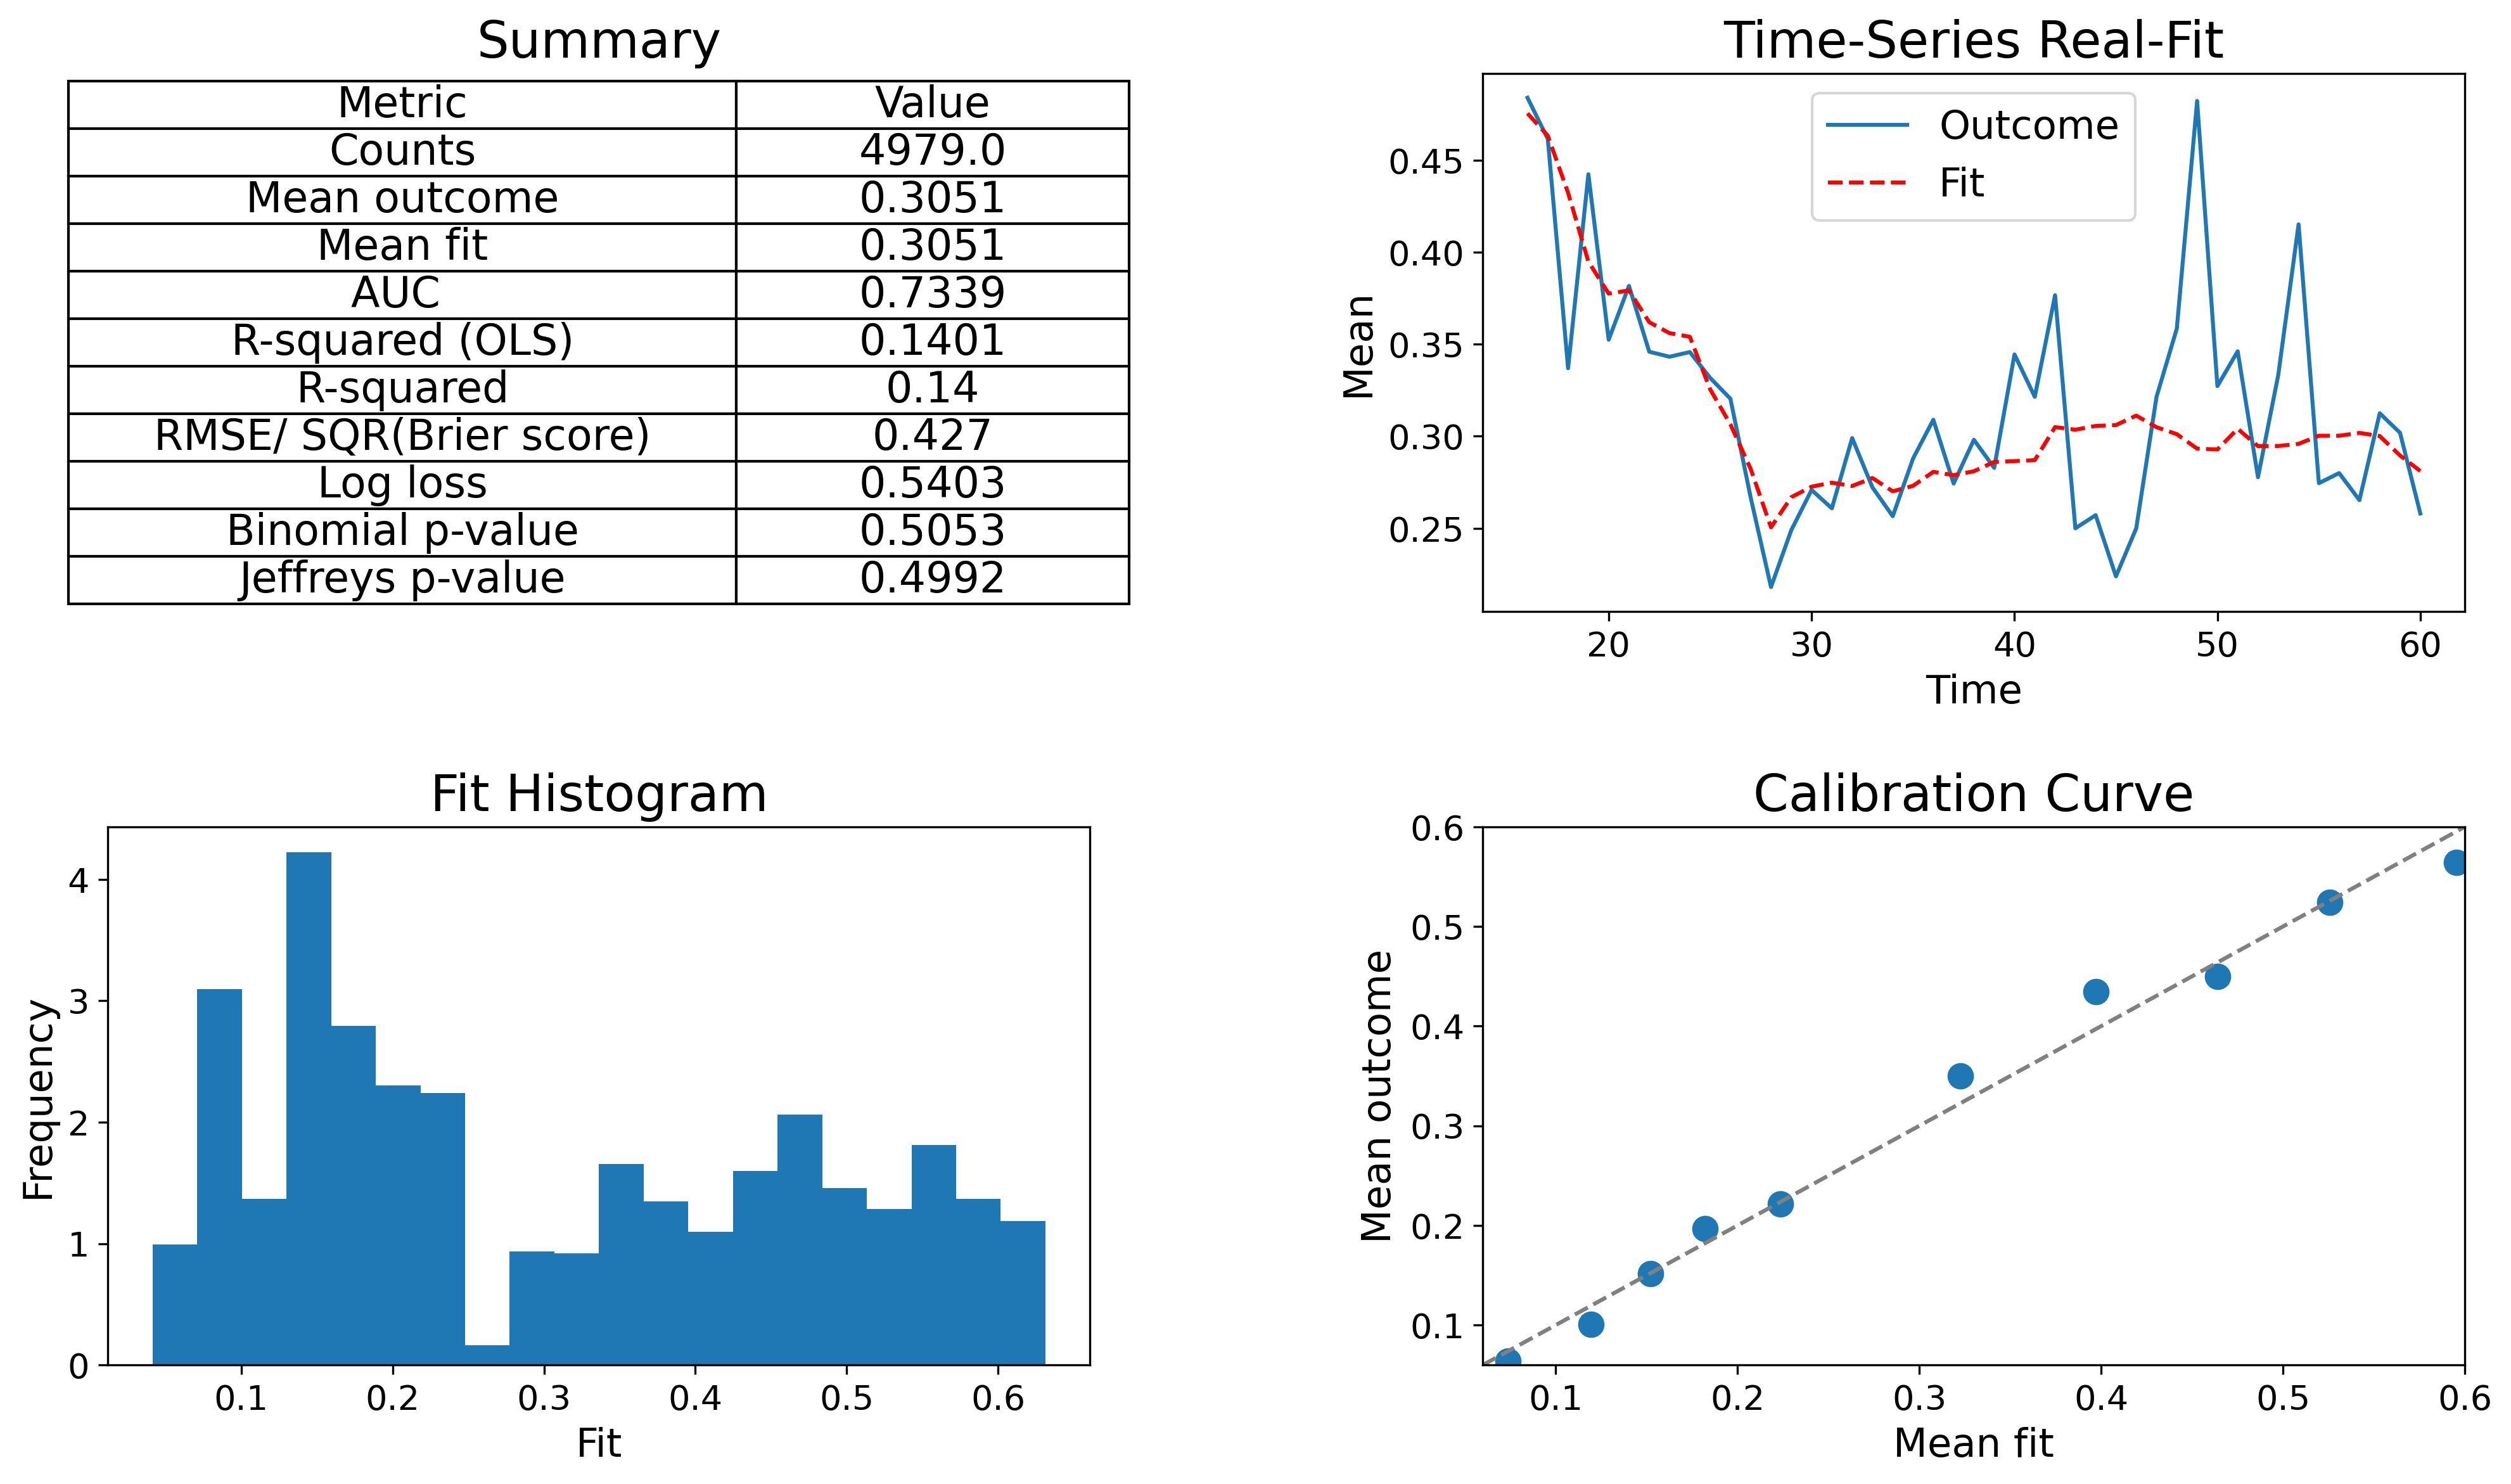

In [82]:
PD_logit_model = pd.DataFrame(pronostico, columns=['PD_logit_model'])
data2 = pd.merge(data_time[['default_time','time']],
                 PD_logit_model, right_index=True, left_index=True)
validation(data2.PD_logit_model, data2.default_time, data2.time)

Notemos que el ajuste al modelo es bueno a excecpción de los trimestres ubicados entre 40-50, los cuales son atípicos en el sentido de que en dicho periodo de tiempo fue el origen de la [crisis financiera del 2008](https://es.wikipedia.org/wiki/Crisis_financiera_de_2008).

Como comparación al modelo obtenido se utilizará el modelo modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html)

In [83]:
model_score = smf.glm('default_time ~ FICO_orig_time_WOE + LTV_orig_time_WOE + \
                      Interest_Rate_orig_time_WOE + hpi_orig_time_WOE', 
                      family = sm.families.Binomial(), data = data_score_regresion).fit()

A continuación se analizarán los coeficientes y *p-value* de cada feature obtenidos del modelo.

In [84]:
print(model_score.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                 4979
Model:                            GLM   Df Residuals:                     4974
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2690.2
Date:                Mon, 07 Dec 2020   Deviance:                       5380.5
Time:                        03:24:45   Pearson chi2:                 4.90e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Nótese que los coeficientes son muy parecidos, sin embargo, calcularemos la norma como medida de error entre ambos vectores de parámetros tomando como valores "reales" los del modelo obtenido con la paquetería mencionada.

In [85]:
print('Error de estimación: ', np.linalg.norm( model_score.params - model))

Error de estimación:  2.9907093027819095e-07


### Resultados

Nótese que todas los parámetros tienen un coeficiente positivo, por los que incrementos en cada una de ellos tendrán un efecto (no directamente proporcional) positivo en la estimación de la probabilidad para determinar si un préstamo será catalogado como default o no. 

Complementando nuestro análisis con el análisis obtenido con la paquetería **glm**, podemos observar que todas las variables son significativas, es decir, el *valor-p* de cada una de las variables es pequeño, lo cual nos indica que en conjunto todas las variables ayudan a explicar la varianza de la variable dependiente. Es decir, aportan información para la clasificación que se busca realizar.

### Hallazgos importantes

Nuestro modelo arroja resultados satisfactorios en tanto lo analizamos bajo distintas métricas que definimos como marco de referencia. En un primer termino las medias de las probabilidades empíricas y del modelo son exactamente las mismas .305. Asimismo, exite una perfecta correspondecia entre los valores de las medias empíricas de origen de cada observación y las del modelo, que podemos apreciar en la gráfica inferior derecha.
Entre otras métricas que seleccionamos tenemos "roc-auc" que se utiliza para determinar cuándo un clasificador realiza la predicción correcta. En nuestro modelo debemos se espera tener una adecuada predicción entre los "defaults" y los "no-defaults". Nuestro modelo tiene una probabiliad de.73 de que una muestra positiva aleatoria tenga una puntuación más alta que una muestra negativa aleatoria.

Al igual que en el modelo de estimación de probabilidad de incumplimiento en el tiempo, la prueba binomial obtiene la probabilidad de obtener el número total de "defaults" emípiricos del total de observaciones de nuestra base cuando la probabilidad de "default" es igual a la media de las probabilidades del modelo.En el modelo de "credir-scoring" el valor de prueba binomial es de .50, con lo que bajo un nivel de signicancia de 5% no podemos rechazar la hipótesis de que la probabilidad de obtener "default" es igual al la media del modelo.


Realización de la tabla por cada perido de tiempo con la variable indicadora de "default" versus "no-default" con su respectiva probabilidad

### Hallazgos Importantes

En nuestro primer acercamiento encontramos resultados muy satisfactorios, lo que podemos apreciar bajo distintas métricas. Las medias de las probabilidades empíricas y del modelo son exactamente las mismas .0245. En la gráfica inferior derecha podemos apreciar la correspondencia entre los valores de las medias empíricas y las del modelo sobre la línea de 45°.

Del mismo modo los resultados coinciden con eventos empíricos asociados a nuestro tema de estudio. Como podemos observar en la gráfica superior derecha se eleva la probabiliad de incumplimiento durante el trimestre 32, aproximadamente, que corresponde al año 2008, cuando se presentó la crisis desatada en Estados Unidos debido al colapso de la burbuja inmobiliaria de 2006. Esta crisis trajó como consecuencia una fuerte contracción en la actividad económica y el empleo. 

Asimismo, los primeros trimestres que abarcan el periodo del 2001 reflejan la crisis en el mercado accionario causada por el estallido de la burbuja de las compañias de internet, que aumentó la percepción de riesgo de los intrumentos de créditos y la probabilidad de impago asociado.

Los resultados de otra métricas como la prueba "roc-auc" que se utiliza para determinar cuándo un clasificador realiza la predicción correcta también dieron resultados satisfactorios. En nuestro modelo debemos realizar una adecuada clasificación entre los "defaults" y los "no-defaults". La curva roc representa la tasa entre la clasificación de verdaderos positivos frente a la de falsos positivos y auc es el aŕea bajo la curva roc, entonces esta última puede ser vista como la probabilidad de que una muestra positiva aleatoria tenga una puntuación más alta que una muestra negativa aleatoria. Un diagnóstico perfecto es de 1, nuestro modelo tiene .73.

En cuanto a "Brier score" también tenemos resultados alentadores. Esta métrica es aplicable a ejercicios de predicción donde se deben asignar probabilidades a conjuntos excluyentes. El "Brier Score" mide la diferencia cuadrática media en entre la probabilidad asignada por el modelo y el resultado real. Por lo tanto, cuanto más baja sea la puntuación mejor se calibrarán las predicciones. El valor de nuestro modelo es tan sólo de .15

Log loss es  también es una función de clasificación que mide la incertidumbre que ha tenido nuestro clasificador con respecto a la etiqueta real que correspondía, es decir, si la clasificación ha variado o desviado mucho o
poco con respecto a lo que debía ser. Lo que se pretende es que este valor sea lo más
cercano a 0. Lo que hace es cuantificar la precisión del clasificador penalizando las
clasificaciones falsas. Minimizando este valor quiere decir que maximizamos la precisión del
clasificador Si tuvieramos un valor cercano a .5 la clasificación entre mis grupos "default" y "no-default"sería neutral es decir se asignaría la misma probabilidad a ambas clases, pero en general valores más pequeños nos hablan de mejores predicciones. En nuestro modelo es de .10

La prueba binomial que presentamos calcula la probabilidad de obtener el número total de "defaults" emípiricos del total de observaciones de nuestra base si la probabilidad de "default" es igual a la media de las probabilidades del modelo.En nuestro modelo el valor de prueba binomial es de .50, con lo que bajo un nivel de signicancia de 5% no podemos rechazar la hipótesis de que la probabilidad de obtener "default" es igual al la media del modelo.

### Iniciamos con introducción de nuevas variables y filtro de otras varibles

#### Para ejemplificar la reduccion de dimensionalidad se usará la varieble state_orig_time

In [88]:
data['state_orig_time'].value_counts()

CA    12582
FL     6175
TX     3893
NY     2947
GA     2649
IL     2350
AZ     2171
VA     2070
OH     1726
PA     1714
MI     1615
MD     1591
NV     1572
WA     1562
NJ     1510
CO     1499
NC     1397
MA     1042
OR      963
IN      923
MO      836
CT      788
MN      781
LA      755
AL      701
TN      700
SC      638
PR      414
MS      370
AR      364
WI      342
UT      340
HI      325
NM      290
KY      286
NH      285
OK      283
KS      255
IA      157
ID      157
DC      156
ME      119
DE      110
RI       93
NE       67
WV       54
WY       51
VT       40
MT       36
AK       24
SD       20
ND       15
Name: state_orig_time, dtype: int64

Una forma de tomar la variable es haciendo una dummy para cada variable, pero eso haría que tengamos más de 100 varibles, por lo tanto reducimos la dimecionalidad con PCA()Una forma de tomar la variable es haciendo una dummy para cada variable, pero eso haría que tengamos más de 100 varibles, por lo tanto reducimos la dimecionalidad con PCA()

Calculamos las tasas por default

In [89]:
scaler = StandardScaler()
defaultrates_states1 = data.groupby(['time', 'state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('default_rate').fillna(0)
defaultrates_states = scaler.fit_transform(defaultrates_states1)

Aplicamos PCA

In [95]:
eigvl, eigvc = potencia(defaultrates_states)
print(eigvl[-1])
print(eigvc)

378.2461944998391
[-0.12987792 -0.12987792 -0.11826901 -0.08189855 -0.13138692 -0.16190696
 -0.11513761 -0.12886578 -0.12703405 -0.08074331 -0.12947654 -0.08892721
 -0.05119609 -0.13167224 -0.12903447  0.07672438 -0.13511702 -0.08661933
 -0.04760763 -0.10280111 -0.03346108 -0.10567496 -0.07118299 -0.10467468
 -0.05327099 -0.07234278  0.0828321  -0.03432779  0.14928932  0.03551719
  0.16100153  0.26432105  0.17062845  0.19392679  0.31075533  0.39448254
  0.36490488  0.14632234  0.08200271  0.0971058   0.08162418  0.01591879
  0.0853674  -0.01119151  0.16077657  0.00323924  0.0416193   0.05556687
  0.03323855  0.01997324 -0.04904423  0.0333099  -0.03602426 -0.07090346
  0.04459041 -0.06005122 -0.08164849 -0.02394981 -0.0547947  -0.13504628]


In [96]:
eigvl2, eigvc2 = second_potencia(defaultrates_states)
print(eigvl2[-1])
print(eigvc2)

174.49552114554078
[ 5.73621936e-05  5.73621936e-05  8.48178603e-02  6.68271421e-03
 -1.15027308e-01 -1.36218533e-01  2.40117535e-01  6.57492081e-02
  1.83355337e-02 -2.22960276e-01  1.76014706e-02 -1.24263662e-02
  1.19188488e-01 -3.88224512e-02  5.48005671e-02  5.64493752e-01
 -2.10094524e-02 -7.77091237e-02 -1.58357380e-01 -8.36003514e-02
  1.06559928e-01 -4.99673824e-02 -3.45730160e-02  2.17163523e-02
  3.05391333e-03 -4.10892867e-02  5.21361739e-02 -1.21564547e-01
 -1.02807841e-02 -9.96529783e-02 -1.09189435e-01 -5.01076238e-02
 -1.02064454e-02 -4.00523221e-06  3.73903852e-01 -2.64245852e-01
 -7.01554695e-02 -3.47053584e-02 -2.15968932e-02 -7.64297044e-02
 -6.20152608e-02  1.50426921e-01 -4.35093349e-02 -1.79217691e-01
 -6.48461401e-02  1.83265161e-01 -3.10722799e-03 -1.19480153e-02
 -3.67609822e-02  4.55491757e-02  2.78853813e-02 -1.17771302e-01
 -1.65789109e-02  1.04454697e-01  2.44229754e-01 -3.04170495e-02
  8.77663954e-03 -4.25509878e-02 -3.19703646e-02  6.73349047e-03]


In [99]:
l,c = np.linalg.eig(defaultrates_states@defaultrates_states.T)
print(l[0:2])
print(c[:,0], c[:,1])

[378.2461945 +0.j 174.49552873+0.j]
[ 0.12987792+0.j  0.12987792+0.j  0.11826901+0.j  0.08189855+0.j
  0.13138692+0.j  0.16190696+0.j  0.11513761+0.j  0.12886578+0.j
  0.12703405+0.j  0.08074331+0.j  0.12947654+0.j  0.08892721+0.j
  0.05119609+0.j  0.13167224+0.j  0.12903447+0.j -0.07672438+0.j
  0.13511702+0.j  0.08661933+0.j  0.04760763+0.j  0.10280111+0.j
  0.03346108+0.j  0.10567496+0.j  0.07118299+0.j  0.10467468+0.j
  0.05327099+0.j  0.07234278+0.j -0.0828321 +0.j  0.03432779+0.j
 -0.14928932+0.j -0.03551719+0.j -0.16100153+0.j -0.26432105+0.j
 -0.17062845+0.j -0.19392679+0.j -0.31075533+0.j -0.39448254+0.j
 -0.36490488+0.j -0.14632234+0.j -0.08200271+0.j -0.0971058 +0.j
 -0.08162418+0.j -0.01591879+0.j -0.0853674 +0.j  0.01119151+0.j
 -0.16077657+0.j -0.00323924+0.j -0.0416193 +0.j -0.05556687+0.j
 -0.03323855+0.j -0.01997324+0.j  0.04904423+0.j -0.0333099 +0.j
  0.03602426+0.j  0.07090346+0.j -0.04459041+0.j  0.06005122+0.j
  0.08164849+0.j  0.02394981+0.j  0.0547947 +0.j  0.13

<function matplotlib.pyplot.show(close=None, block=None)>

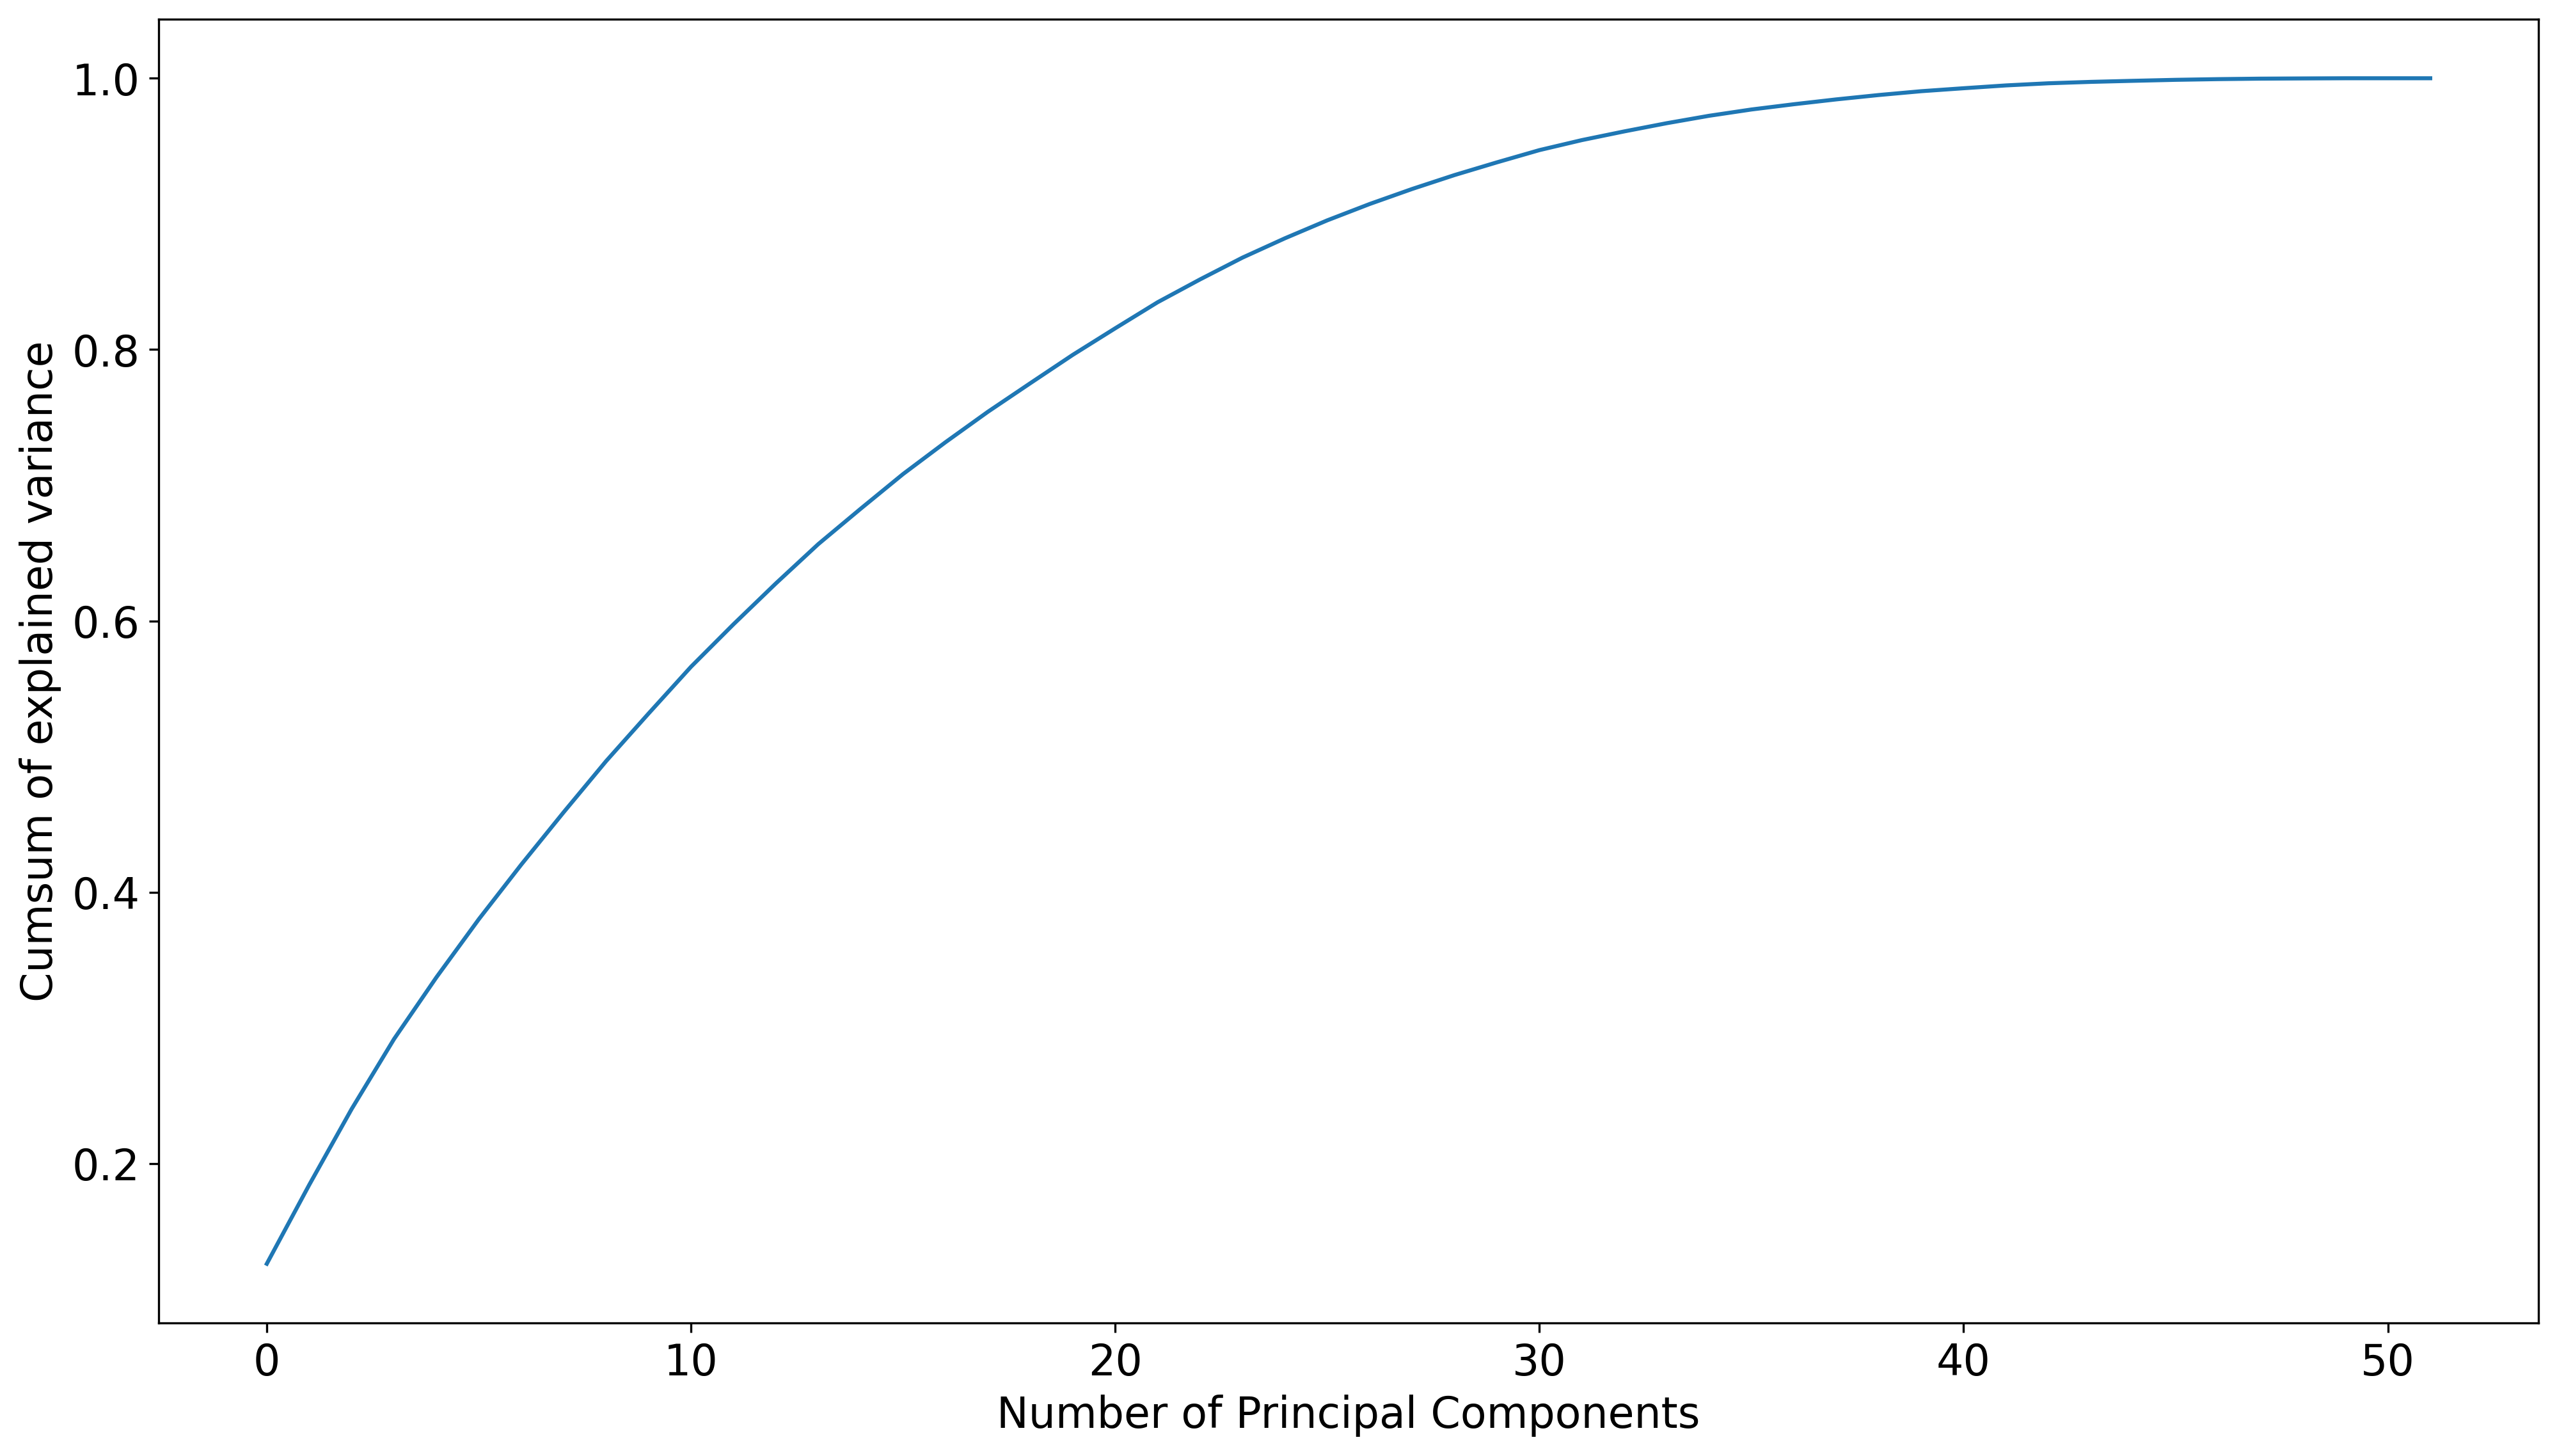

In [45]:
pca = PCA()
pca.fit(defaultrates_states)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumsum of explained variance')
plt.show

ValueError: x and y must have same first dimension, but have shapes (60,) and (0, 52)

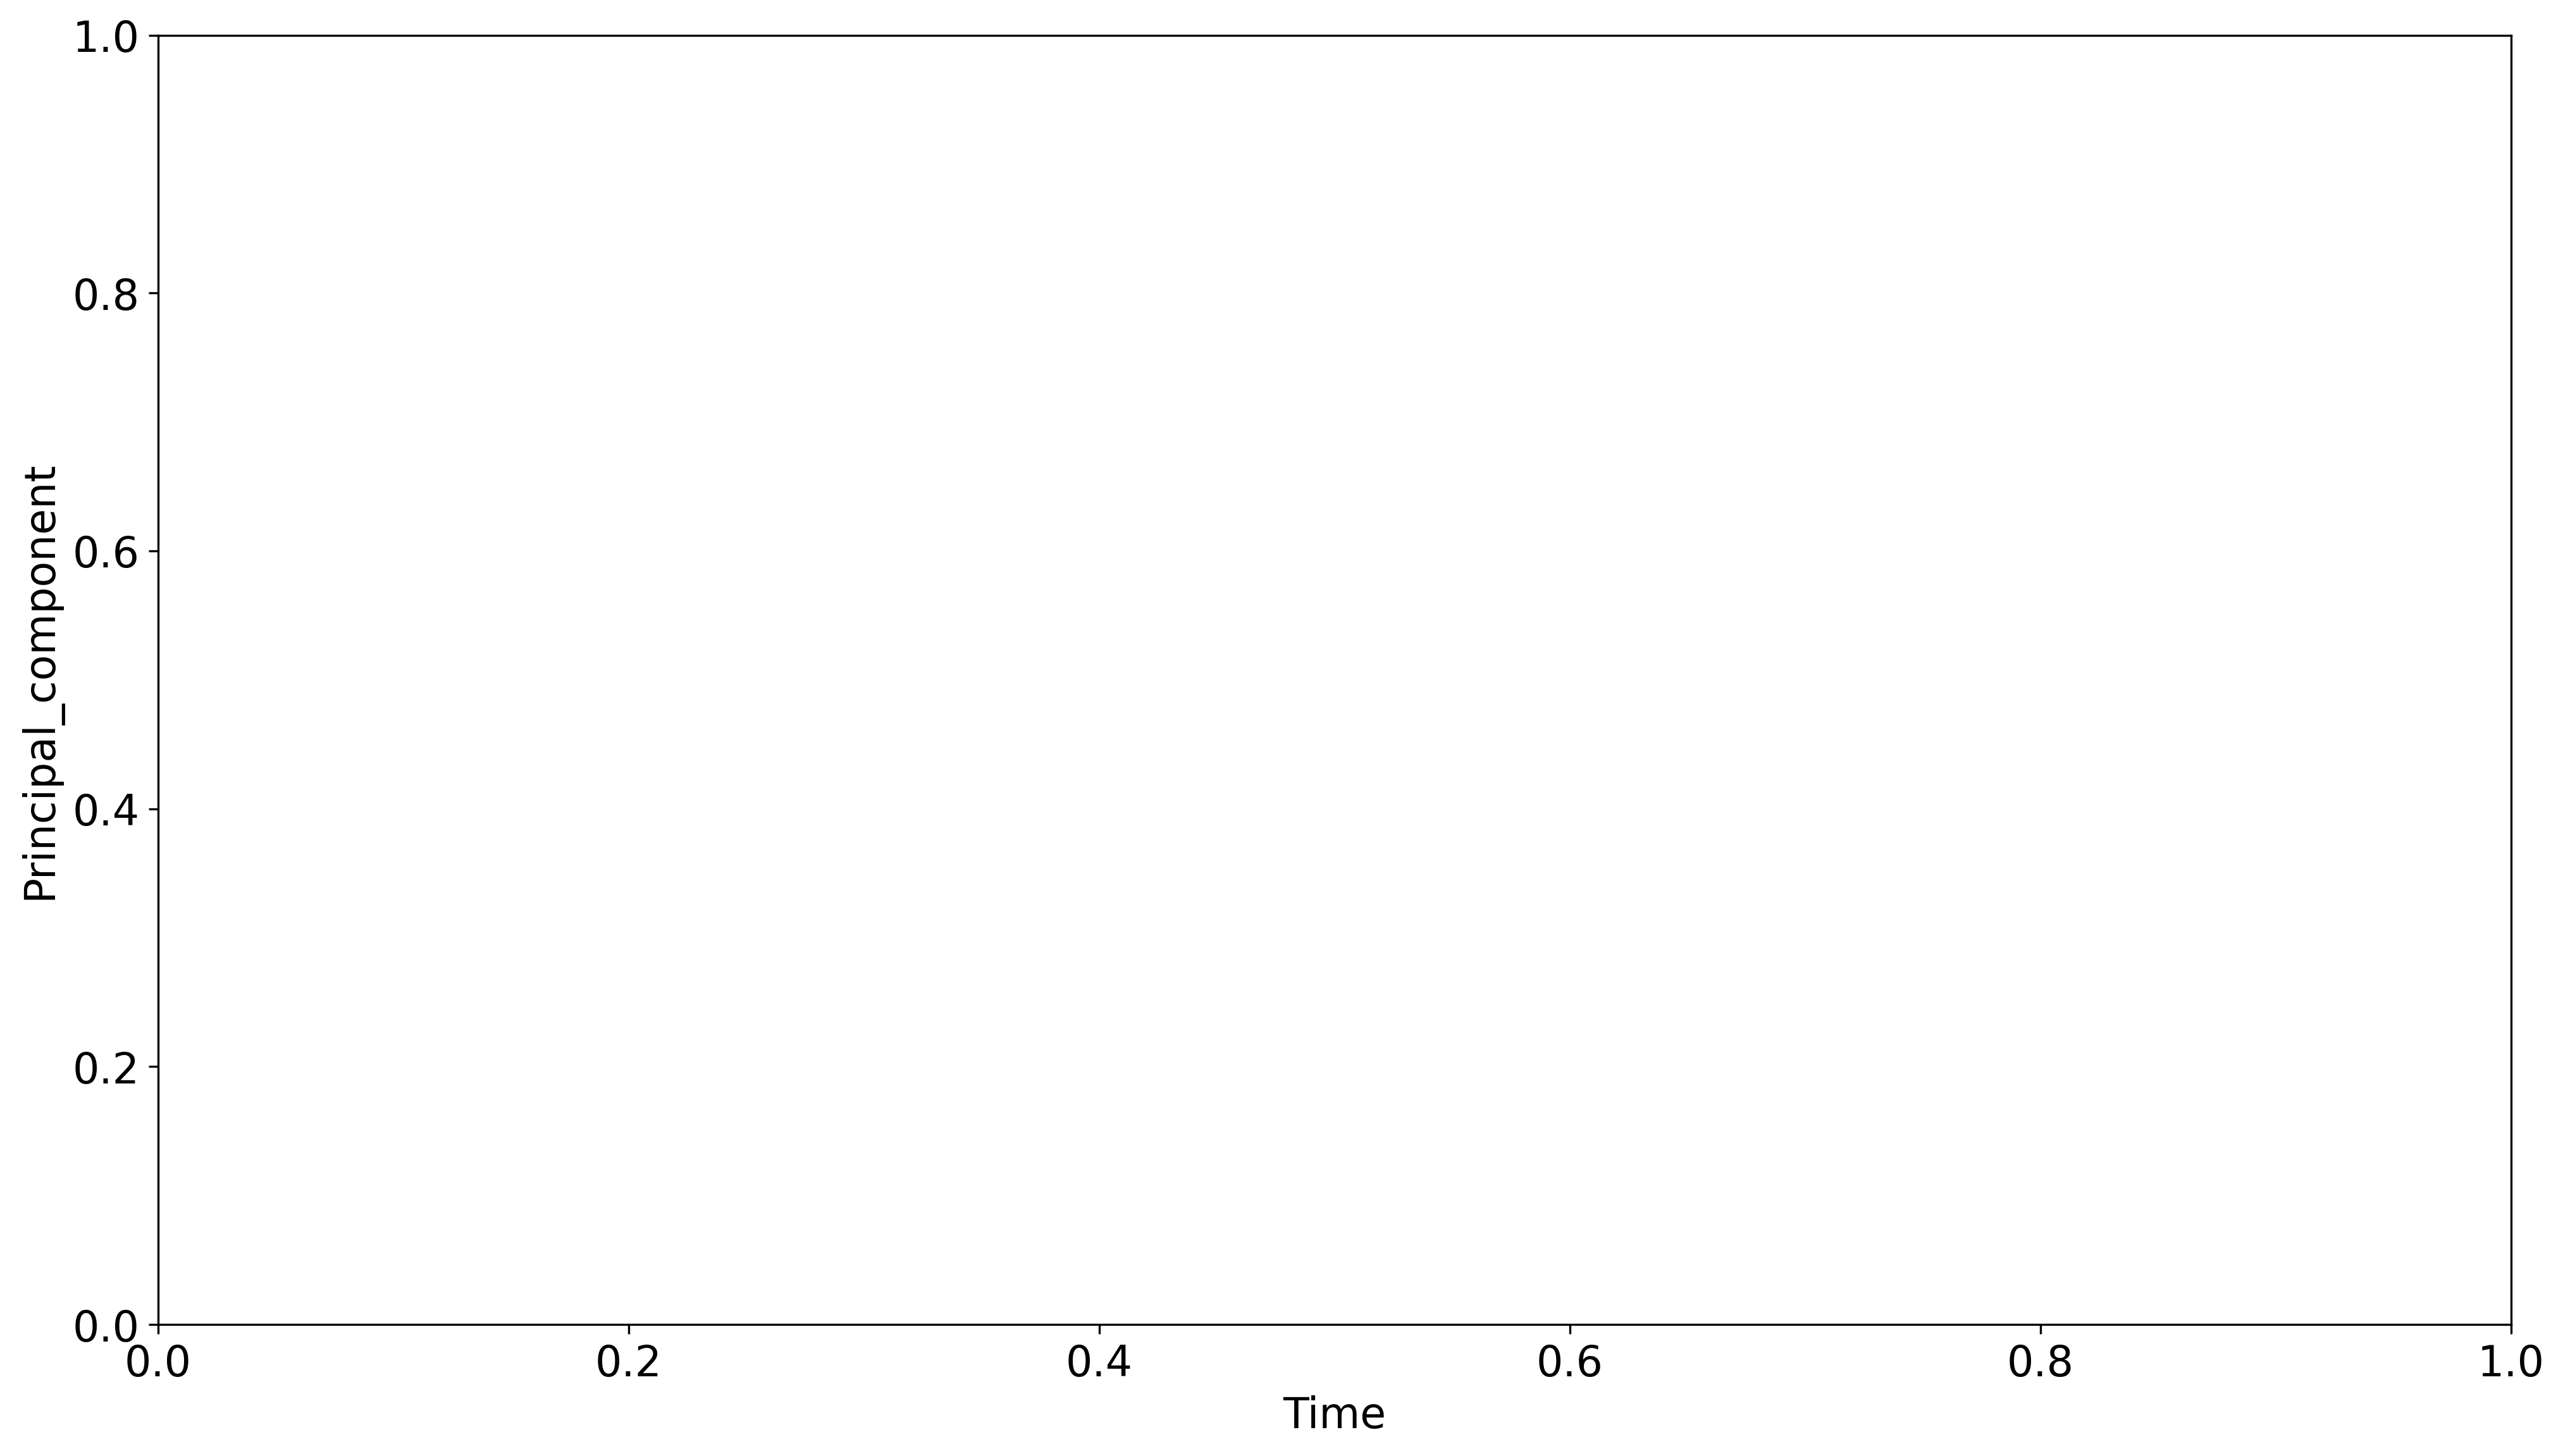

In [46]:
# Graficamos 2 compnentes principales

Z = pca.transform(defaultrates_states)

plt.xlabel('Time')
plt.ylabel('Principal_component')
plt.plot(defaultrates_states1.index, Z[:0], alpha=1, label="First PC")
plt.plot(defaultrates_states1.index, Z[:1], alpha=1, color = 'red', linestyle='dashed',label="Second PC")
plt.legend(loc='best')
plt.show

# COMENTARIOS REPORTE ESCRITO
1. La parte faltante es el plot e componentes principales, arreglar el correspondiente `bug`
1. Limpiar el reporte en el sentido de no leer 3 veces la base de datos, sino una vez y sobre la misma base de datos trabajar (realizar una copia/respaldo)
1. Agregar fórmulas matemáticas